# Severity of adverse reactions in pediatric patients

In [1]:
import collect_data 
import clean_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import scipy.stats as st
plt.style.use('seaborn')

url_base = "https://api.fda.gov/drug/event.json?search=receivedate:[20030101+TO+20200528]"

## Collecting the pediatric dataset

We will first collect the data. We will initially collect only data for 'children' i.e. category 3 as reported in the database. This does not include neonates, infants or adolescents.

Given the total number of children in the database (35,000), we will initially restrict our analyses to the first 5000, before later expanding the sample. 

## Cleaning the data

In [2]:
n_reports = 5000

# collect pediatric data from database and normalise
raw_pediatric = collect_data.collect_pediatric_data(n_reports)
raw_pediatric.reset_index(drop=True, inplace=True)
flat_pediatric = collect_data.flatten_dataframe(raw_pediatric)

We clean the data to remove unecessary/undesired columns, impute missing values, remove columns with a high fraction of missing values, format types appropriately, and filter any outliers.

In [3]:
clean_pediatric = clean_data.drop_unnecessary_columns(flat_pediatric)
clean_pediatric = clean_data.fill_seriousness_nan(clean_pediatric)
clean_pediatric = clean_data.remove_nan_columns(clean_pediatric, 40)
clean_pediatric = clean_data.fix_data_types(clean_pediatric)
clean_pediatric = clean_data.reformat_onsetage(clean_pediatric)
clean_pediatric = clean_data.remove_outliers(clean_pediatric)
clean_pediatric.serious = clean_pediatric.serious.map({2:0, 1:1}) #map_serious_to_boolean
pediatric_data = clean_pediatric.reset_index()

In [4]:
pediatric_data.head(10)

,index,reporttype,occurcountry,serious,primarysource.qualification,patient.patientsex,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,seriousnessdeath,seriousnessdisabling,seriousnesscongenitalanomali,reactionoutcome,reactionmeddrapt,route,patient.patientonsetageyear
0,0,1.0,US,0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Sinusitis,ORAL,10.0
1,1,1.0,US,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Hiccups,ORAL,4.0
2,2,1.0,US,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Hordeolum,ORAL,4.0
3,3,1.0,US,0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Oral candidiasis,ORAL,2.0
4,4,1.0,US,0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Nasopharyngitis,ORAL,5.0
5,5,1.0,US,1,5.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,Coeliac disease,ORAL,13.0
6,6,1.0,US,0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Heart rate increased,ORAL,7.0
7,7,1.0,US,0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Dyspnoea,ORAL,6.0
8,8,1.0,US,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Sinusitis,ORAL,6.0
9,9,1.0,US,0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,Sinusitis,ORAL,8.0


Examine the dataset by eye to look for anomalies and problems.

In [5]:
pediatric_data.describe()

,index,reporttype,serious,primarysource.qualification,patient.patientsex,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,seriousnessdeath,seriousnessdisabling,seriousnesscongenitalanomali,reactionoutcome,patient.patientonsetageyear
count,4991.000000,4991.000000,4991.000000,4974.000000,4030.000000,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000,4991.000000,4870.000000,2586.000000
mean,2498.518734,1.257864,0.535965,3.488741,1.331266,0.364857,0.166299,0.017832,0.048487,0.006211,0.003206,4.596099,7.881574
std,1443.076841,0.450591,0.498755,1.703362,0.470727,0.481438,0.372386,0.132354,0.214815,0.078574,0.056534,2.000540,3.320164
min,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.666667
25%,1249.500000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,5.000000
50%,2497.000000,1.000000,1.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,8.000000
75%,3748.500000,2.000000,1.000000,5.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,11.000000
max,4999.000000,4.000000,1.000000,5.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,17.000000


We will now handle any remaining missing data by imputing a new category 'unknown' for the categorical data, and applying a 'mean' or 'most frequent' strategy to the numerical data.


## Exploratory Data Analysis - Pediatric Dataset

Similar to our analysis for the full database (presented in the [Exploring_OpenFDA_Adverse_Reactions notebook](https://github.com/ambevan/OpenFDA_Case_Study/blob/master/Exploring_OpenFDA_Adverse_Reactions.ipynb)), we can now perform some basic analysis and exploration of the cleaned pediatric dataset before building a more sophisticated model. We are predominantly interested in the severity of the adverse effect and so we start by exploring this feature.

We can see that the fraction of reported serious adverse responses is similar to the entire population (54% compared to 59%). Of those where the nature of the serious reponse is reported, the majority (60%) report a response that did not result in death, disability, congenital anomali, a threat to lif or hospitalisation.

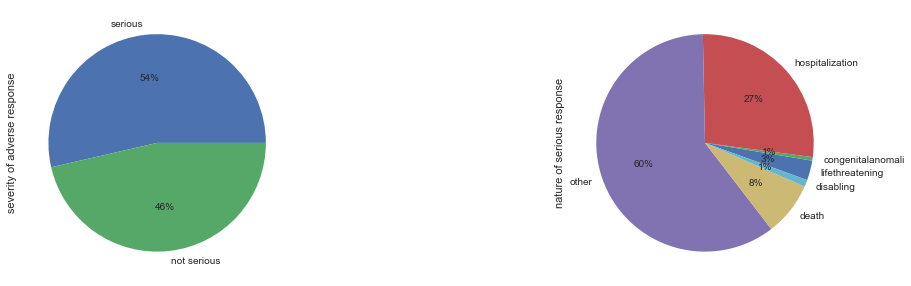

In [6]:
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,5))
pediatric_data.serious.value_counts().plot.pie(labels=['serious','not serious'], ax=ax1, autopct='%1.0f%%');
ax1.set_ylabel('severity of adverse response');

seriousness_col_names = ['seriousnesslifethreatening',
                         'seriousnesscongenitalanomali',
                         'seriousnesshospitalization', 
                         'seriousnessother',
                         'seriousnessdeath' ,
                         'seriousnessdisabling'
                        ]
labels = [item.replace('seriousness','') for item in seriousness_col_names]
df_serious = pediatric_data[seriousness_col_names]
df_serious.sum().plot.pie(ax=ax2, autopct='%1.0f%%', labels=labels, startangle=-20)
ax2.set_ylabel('nature of serious response');

Two different but comparable metrics exist within the database that give an indication of severity. We can gain some undersading of the accuracy of teh data by comparing these metrics. We know whether the outcome was classified as 'serious' or 'not serious'. We also have the nature of the outcome as falling into one of these categories:

* 1 = Recovered/resolved
* 2 = Recovering/resolving
* 3 = Not recovered/not resolved
* 4 = Recovered/resolved with sequelae (consequent health issues)
* 5 = Fatal
* 6 = Unknown

We can examine the relative frequencies of these outcomes in our data (ignoring any blanks or unknowns).

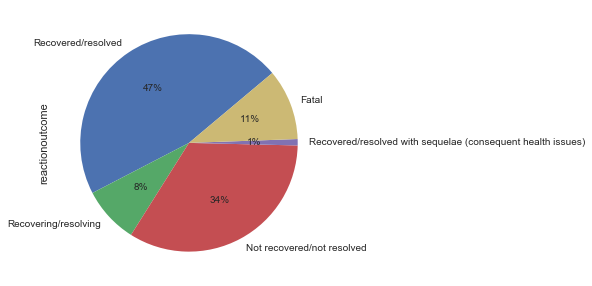

In [7]:
outcome_df = pediatric_data.reactionoutcome.value_counts()
outcome_df.sort_index(inplace=True)
labels_dict = {1 : 'Recovered/resolved',
               2 : 'Recovering/resolving',
               3 : 'Not recovered/not resolved',
               4 : 'Recovered/resolved with sequelae (consequent health issues)',
               5 : 'Fatal',
               6 : 'Unknown'
              }
ax1 = outcome_df[outcome_df.index != 6].plot.pie(autopct='%1.0f%%', labels=labels_dict.values(), figsize=(5,5), startangle=40);                 

It is important to note that many reports indicate multiple serious outcomes, for example hospitalization and death are not mutually exclusive. 

#There is some more data analysis to be done here.

In [8]:
pediatric_data.isna().sum()

index                              0
reporttype                         0
occurcountry                      40
serious                            0
primarysource.qualification       17
patient.patientsex               961
seriousnessother                   0
seriousnesshospitalization         0
seriousnesslifethreatening         0
seriousnessdeath                   0
seriousnessdisabling               0
seriousnesscongenitalanomali       0
reactionoutcome                  121
reactionmeddrapt                   0
route                           1038
patient.patientonsetageyear     2405
dtype: int64

## Analysis of factors influencing severity of adverse response in children

Initally, we will build a logistic regression model to predict whether or not an adverse response is serious given some of the other variables. We will initially consider a model with only a few features: patient age and patient gender.

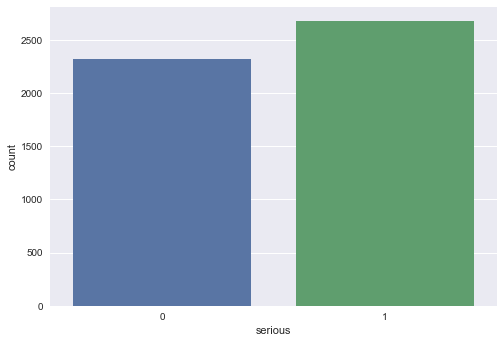

In [9]:
sns.countplot(x='serious',data=pediatric_data);

In [10]:
pediatric_data.groupby('serious').mean()

,index,reporttype,primarysource.qualification,patient.patientsex,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,seriousnessdeath,seriousnessdisabling,seriousnesscongenitalanomali,reactionoutcome,patient.patientonsetageyear
serious,,,,,,,,,,,,
0,2894.278929,1.145509,4.163424,1.310559,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,4.856007,8.076423
1,2155.871776,1.355140,2.902292,1.350334,0.680748,0.31028,0.033271,0.090467,0.011589,0.005981,4.370299,7.711292


It seems that patients serious responses are more likely to be observed in slightly younger patients. By considering the distribution of ages for serious and not serious responses, we can see that the less serious responses are more skewed to older children.

z = 0.0781  critical value = 1.64
Insufficient evidence to reject null hypothesis.


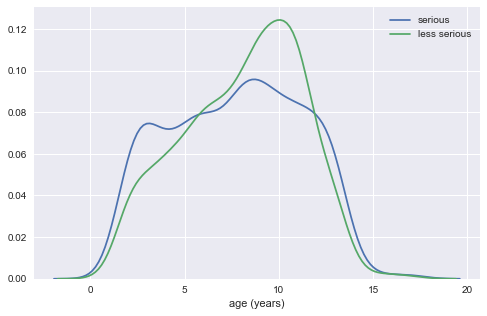

In [11]:
fig = plt.figure(figsize=(8,5))
serious_1 = pediatric_data.loc[pediatric_data.serious==1,'patient.patientonsetageyear']
serious_0 = pediatric_data.loc[pediatric_data.serious==0,'patient.patientonsetageyear']
sns.kdeplot(serious_1, label='serious');
sns.kdeplot(serious_0, label='less serious');
plt.xlabel('age (years)');

def z_test(series1, series2, prob):
    sd1 = series1.std()
    sd2 = series2.std()
    mu1 = series1.mean()
    mu2 = series2.mean()
    z = (mu1-mu2)/(sd1**2 + sd2**2)**0.5
    crit = st.norm.ppf(prob)
    print(f'z = {z:.3}  critical value = {crit:.3}')
    if z < crit:
        print('Insufficient evidence to reject null hypothesis.')
    return z

#perform z test to compare means of distributions
z = z_test(serious_0,serious_1, 0.95)



We can also consider the correlation with gender using a contingency table. We can see from the table (which is not noramlised and represens abolute frequencies in the data), that there are significantly more reports of adverse reponses in male patients in the database. This might suggest that male patients are more likely to suffer adverse respones or that they are more likely to report adverse responses than female patients (or both). 

One indication that suggests male patients might simply be more likely to report adverse effects (either directly or through a clinician) is that, of female reports, 55% of reports were for serious adverse effects compared to 45% for not serious. The number of serious and non-serious adverse reports for male patients in the data is 50:50.

In [12]:
def add_labels(ax, pivot):
    p_all = ax.patches
    for i, p in enumerate(ax.patches):
        if (i % 2):
            j=int((i)/2)
            ax.annotate(f'n = {pivot.total[j]:.0f}', 
                        (p_all[j].get_x(), 
                         max(p_all[j+len(pivot)].get_height(),p_all[j].get_height()) * 1.01))

def calculate_serious_pivot(data, index):
    sub_data = pd.pivot_table(data, values=['index'],  index=index, columns=['serious'], aggfunc='count')
    sub_data = sub_data[sub_data.notna().all(axis=1)]
    sub_data['total'] = sub_data.sum(axis=1)
    sub_data.columns = ['not serious','serious','total']
    sub_data[['not serious %','serious %']] = sub_data[['not serious', 'serious']].div(sub_data.total, axis=0).multiply(100)
    return sub_data
    
def plot_serious_pivot(pivot, index, ax=None, annotate=False):
    ax = ax or plt.gca()
    ax = pivot[['not serious %','serious %']].plot.bar(figsize=(15,8), ax=ax);
    ax.set_ylabel('%');
    ax.legend(labels=['not serious', 'serious'])
    if annotate:
        add_labels(ax, pivot)
    return ax

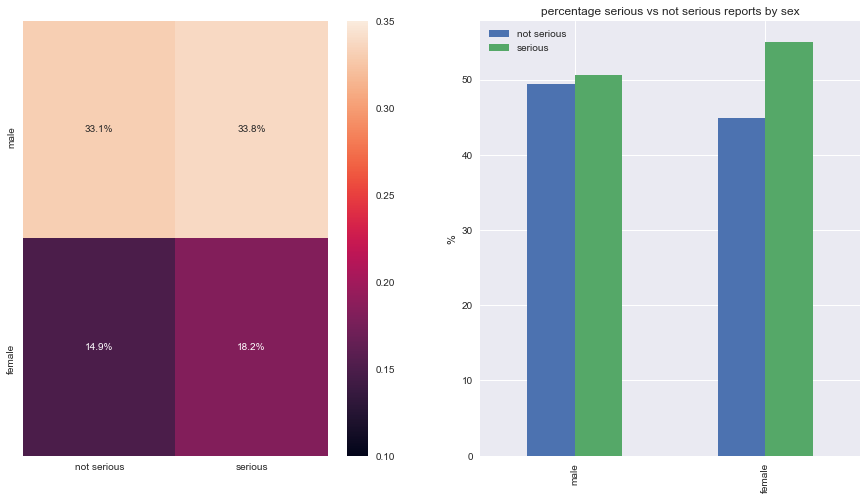

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(18,5))
df = pediatric_data
sub_data = pd.pivot_table(df, values=['index'],  index=['serious'], columns=['patient.patientsex'], aggfunc='count')
total_count = (sub_data.sum().sum())
sub_data = sub_data.divide(total_count)
sex_columns = {1 : 'male', 2 : 'female','index':'gender'}
sub_data = sub_data.rename(columns=sex_columns)

pivot_tb = calculate_serious_pivot(pediatric_data, 'patient.patientsex')
tb = pivot_tb.drop(columns=['total','not serious %','serious %'])
tb = tb.divide(tb.sum().sum())
ax1 = sns.heatmap(tb,vmin=0.10,vmax=0.35,
                 #norm=LogNorm(vmin=sub_data.min().min(), vmax=sub_data.max().max()),
                 annot=True,
                fmt='.1%', ax=ax1);
ax1.set_xlabel('');
ax1.set_ylabel('');
ax1.set_yticklabels(['male','female']);

plot_serious_pivot(pivot_tb, 'route', ax2)
ax2.set_title('percentage serious vs not serious reports by sex');
ax2.set_xticklabels(['male','female']);
ax2.set_xlabel('');
ax2.set_ylabel('%');

We can calculate pearson's $\chi^2$ correlation coefficient to understand whether these results are significant. We will choose a 95\% confidence interval. 

In [14]:
def significance_test(table, prob):

    chi2_stat, p, dof, expected = chi2_contingency(table)

    # interpret test-statistic
    prob = 0.99
    critical = chi2.ppf(prob, dof)

    print(f"dof = {dof}  "
          f"probability = {prob:.3f} | "
          f"critical = {critical:.3f}   "
          f"chi2 = {chi2_stat:.3f}")
    print()

    if abs(chi2_stat) >= critical:
        print(f'Reject null hypothesis. Variables dependent at the {prob:.0%} confidence level.')
    else:
        print('Do not reject null hypothesis. Insufficiest evidence for dependence.')

significance_test(pivot_tb[['not serious','serious']], 0.99)

dof = 1  probability = 0.990 | critical = 6.635   chi2 = 7.004

Reject null hypothesis. Variables dependent at the 99% confidence level.


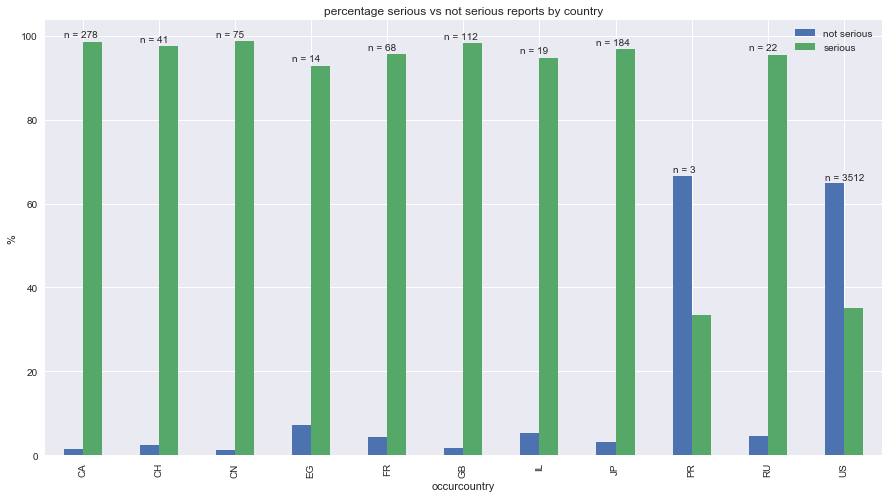

dof = 10  probability = 0.990 | critical = 23.209   chi2 = 1038.201

Reject null hypothesis. Variables dependent at the 99% confidence level.


In [15]:
pivot_tb = calculate_serious_pivot(pediatric_data, 'occurcountry')
ax = plot_serious_pivot(pivot_tb, 'occurcountry', annotate=True)
ax.set_title('percentage serious vs not serious reports by country');
plt.show()

# calculate significance
significance_test(pivot_tb[['not serious','serious']], 0.99) #consider appropriateness of pearson's chi2 here (US dominates)

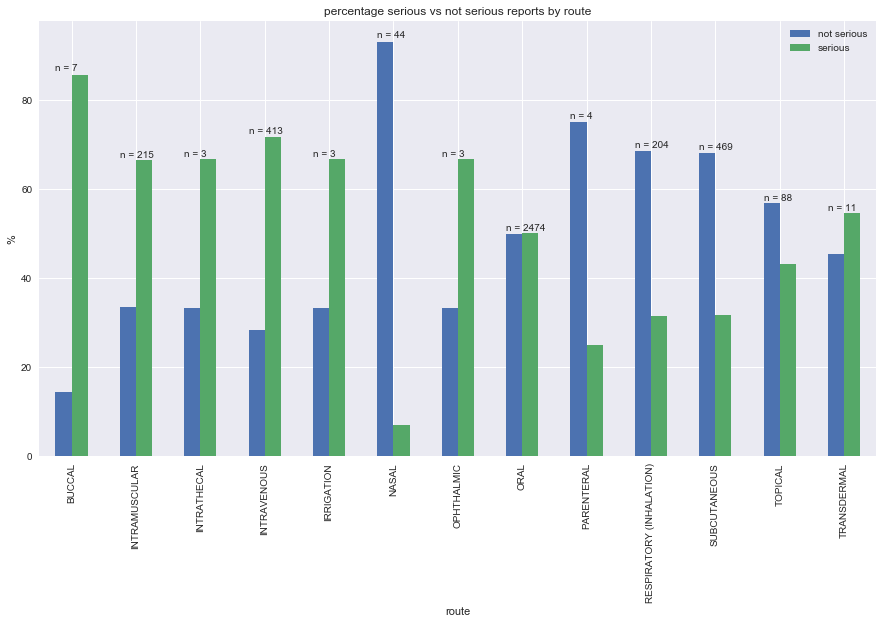

dof = 12  probability = 0.990 | critical = 26.217   chi2 = 231.544

Reject null hypothesis. Variables dependent at the 99% confidence level.


In [16]:
# calculate pivot table for severity against drug administration route
pivot_tb = calculate_serious_pivot(pediatric_data, 'route')
ax = plot_serious_pivot(pivot_tb, 'route', annotate=True)
ax.set_title('percentage serious vs not serious reports by route');
plt.show()

# calculate significance
significance_test(pivot_tb[['not serious','serious']], 0.99)

## Logistic Regression model

I am interested to construct a mode to predict the severity of adverse respones given given certain information about a patient and the drug(s) that they are taking. The model would require significant fine tuning taking longer than the time available to complete this task. However, I include a representative approach using logistic regression to classify severity. This simple model performs poorly but a variety of approaches might improve the accuracy of the model. I discuss these below.

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import process_data as process

I will establish a simple model based only on gender, age of patient and drug administration route. Initially the data needs further cleaning and preprocesing. 

#### Further cleaning of the data

In [18]:
# Shuffle the data in case it is sorted
data = pediatric_data.sample(frac=1).reset_index(drop=True)

# Remove all rows with no gender specified 
# (could have alternatively mapped to additional category)
print(f"{data['patient.patientsex'].isna().sum()} of {data['index'].count()} " 
      f"rows with missing sex removed "
     f"({data['patient.patientsex'].isna().sum()/data['index'].count():.2%})")
data = data[data['patient.patientsex'].notna()]

# Due to small numbers, group least prevalent routes into 'other'
# Kepp only most prevalent routes (>10% of data)
data = process.map_routes(data, 0.1)

# Map routes with missing values to new category 'unknown'
data.route_summary = data.route_summary.fillna('UNKNOWN')

961 of 4991 rows with missing sex removed (19.25%)


#### Impute missing values and construct logistic regressor

In [21]:
# Select features to model
X = data[['patient.patientsex', 'patient.patientonsetageyear', 'route_summary']]
y = data['serious']

# Split into training data and validation data (consider cross-validation later)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

# Imputation: list categorical and numerical columns
cols_cat = ['route_summary']
patient_age = 'patient.patientonsetageyear'
imputed_X_train = X_train.copy()
imputed_X_valid = X_valid.copy()

# Apply label encoder to each column with categorical data
label_encoder = LabelEncoder()
for col in cols_cat:
    imputed_X_train[col] = label_encoder.fit_transform(X_train[col].astype(str))
    imputed_X_valid[col] = label_encoder.transform(X_valid[col].astype(str))

# Imputation: replace missing numerical data with mean value
process.impute_on_mean(imputed_X_train, 'patient.patientonsetageyear')
process.impute_on_mean(imputed_X_valid, 'patient.patientonsetageyear')

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

# define logistic regression model
log_reg = LogisticRegression();
log_reg.fit(imputed_X_train, y_train);

#### Determine accuracy of model

Accuracy of logistic regression classifier on validation set: 0.54


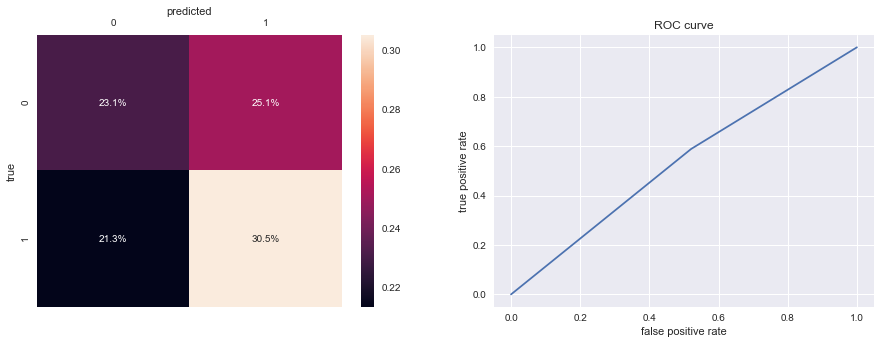

              precision    recall  f1-score   support

           0       0.52      0.48      0.50       582
           1       0.55      0.59      0.57       627

    accuracy                           0.54      1209
   macro avg       0.53      0.53      0.53      1209
weighted avg       0.53      0.54      0.53      1209



In [22]:
# predict 
y_pred = log_reg.predict(imputed_X_valid)
print('Accuracy of logistic regression classifier on validation set: {:.2f}'.format(log_reg.score(imputed_X_valid, y_valid)))
confusion_matrix = metrics.confusion_matrix(y_valid, y_pred)
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,5))
sns.heatmap(confusion_matrix/np.sum(confusion_matrix),annot=True,fmt='.1%',ax=ax1);
ax1.set_xlabel('predicted');
ax1.set_ylabel('true');
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top');

#plot ROC curve
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred)
ax2.plot(fpr, tpr);
ax2.set_xlabel('false positive rate')
ax2.set_ylabel('true positive rate')
ax2.set_title('ROC curve')
plt.show()

print(metrics.classification_report(y_valid, y_pred))

#### Analysis and improvements

[explain the above and what it means]

#### Next steps to improve the model

* Increase the volume of data
* Increase the number of features (e.g. country, drug type, pediatric indication)
* Balance the dataset
* Adjust recategorisation of routes
* Cross-validation

Additionally, I would build the code into a pipeline rather than having each step as laid out above.